# **Quantum Key Distribution with the E91 Protocol**
---

## **Introduction** 
This project extends your work in Week 8 to implement a more advanced Quantum Key Distribution protocol relying upon quantum entanglement: the E91 Protocol. Proposed just 7 years after the BB84 protocol by Artur K. Ekert, this protocol is a strong candidate for securing the quantum and maybe even classical internets of the future. It is particularly powerful because Alice and Bob only need public classical channels and shared Bell pairs whereas BB84 and others also require quantum channels.

<br>

## **Description**
E91 can be broken down into the following steps:

**Phase 1**: Alice Makes Choices and Measures

> **Step 1**: Alice and Bob share a Bell pair.
>
> **Step 2**: Alice randomly chooses 1 of 3 circuits to apply to each of her qubits.
>
> **Step 3**: Alice measures her qubits.

**Phase 2**: Bob Makes Choices and Measures

> **Step 4**: Bob randomly chooses 1 or 3 circuits to apply to each of his qubits.
>
> **Step 5**: Bob measures his qubits.

**Phase 3**: Alice and Bob Compare Choices

> **Step 6**: Alice and Bob compare choices, sorting into two groups:
1. *Matching choices*: Alice and Bob each create their own key from these.
1. *Mismatching choices*: Alice and Bob tell each other their measurement results and test how entangled they were. If Eve has intercepted, the entanglement between Alice and Bob will be less than expected.


<br>

The core ideas behind this protocol are:
* Alice and Bob share maximally entangled qubits to start (Step #1). In practice, this could be implemented using Quantum Repeaters so that Alice and Bob actually never have to meeting for the protocol.
* If Eve intercepts in any way, she will destroy some or all of the entanglement due to the effect of measurement.
* Alice and Bob can determine how much entanglement they have in the end (Step #6), so they can tell if Eve destroyed some or not.
* Alice and Bob only have to communicate classically (Step #6). They never have to send quantum information to each other or even use secure private channels.


<br>

## **Key Questions**
In this project, you will answer the following questions:

1. How does Eve's interception change the amount of entanglement Alice and Bob share? Why?

1. Imagine that Eve attempts to go unnoticed by preparing Alice and Bob's qubits back into the $|\beta_{11}\rangle$ state instead of whatever her measurement results were. Answer these two questions based on this scenario:
  * Would this accomplish Eve's goal of going unnoticed? **Hint**: Think about how the entanglement would or would not change in this case. Consider writing code to test this.
  * Why does this still keep Eve from learning Alice's and Bob's key?

1. In BB84, Alice decides the key at the very beginning and tries communicating it to Bob securely. That is not the case in E91. *When* in the protocol is the key officially created? **Hint**: It's before Alice and Bob actually create their keys.

<br>

## **Structure**
This project is broken into 3 parts:
> **Part 1**: E91 Protocol for One Qubit
>
>> **Part 1.1**: Phase 1 - Alice Makes Choices and Measures
>>
>> **Part 1.2**: Phase 2 - Bob Makes Choices and Measures
>>
>> **Part 1.3**: Phase 3 - Alice and Bob Compare Choices
>
> **Part 2**: E91 Protocol for Multiple Qubits
>
> **Part 3**: Eve Intercepts!
>
> **Wrapping Up**



<br>

## **Resources**
* [Week 8 Lab Solutions (BB84)](https://drive.google.com/file/d/1S-zNslzmNRtH2-sr024ykRueRRwCgb6M/view?usp=share_link)
* [Qiskit Documentation: Z Rotation Gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZGate.html)
* [Youtube: High Level Description of E91 Protocol by Artur Ekert Himself](https://www.youtube.com/watch?v=TyomwLbYhig)
* [Quantum Cryptography Based on Bell's Theorem](http://www.physics.drexel.edu/~bob/Entanglement/Ekert_keydistribution.pdf): The original paper by Artur Ekert proposing this protocol in 1991
* [QuTech Quantum Network Simulator: E91 Protocol](https://www.quantum-network.com/applications/5/)

<br>

**These resources aren't necessary for completing this project, but are provided in case you are curious about the way that entanglement is being tested.**
* [Qiskit Textbook: Local Reality and the CHSH Inequality](https://qiskit.org/textbook/ch-demos/chsh.html)
* [Wikipedia: CHSH Inequality](https://en.wikipedia.org/wiki/CHSH_inequality)
* [Wikipedia: Bell's Theorem](https://en.wikipedia.org/wiki/Bell%27s_theorem)

---

## **Part 0: Importing from Qiskit**
---

**Run the code below to import everything needed for this lab.**

In [1]:
#!pip install qiskit

from qiskit import QuantumCircuit, Aer, transpile, assemble, execute, IBMQ
from qiskit.visualization import plot_histogram

import numpy as np
import random
import math

import warnings
warnings.filterwarnings('ignore')


# Determine the amount of entanglement between these bits using the CHSH value
def entanglement_amount(alice_choices, alice_bits, bob_choices, bob_bits):
    
  # count the different measurement results
  # rows correspond to Alice and Bob's circuit choices: 00, 02, 20, 22
  # NOTE: We do not consider circuits 1 or 3 for this test
  # columns correspond to Alice and Bob's qubit measurements: 00, 01, 10, and 11
  circuits = {'00': 0, '02': 1, '20': 2, '22': 3}
  counts = [[0]*4 for i in range(4)]
  for i in range(len(alice_choices)):
    circuit = str(alice_choices[i]) + str(bob_choices[i])
    state = int(alice_bits[i]) + 2*int(bob_bits[i])

    if circuit in circuits: counts[circuits[circuit]][state] += 1


  # expectation values calculated by 
  # adding times Alice and Bob's bits agreed and
  # subtracting times Alice and Bob's bits disagreed
  expectations = []

  for circuit in range(4):
    expectations += [counts[circuit][0] + counts[circuit][3] - counts[circuit][1] - counts[circuit][2]]
    total = sum(counts[circuit])

    if total != 0: expectations[circuit] /= total


  # returning CHSH correlation
  return expectations[0] - expectations[1] + expectations[2] + expectations[3]
  

print("Libraries Imported Successfully!")

Libraries Imported Successfully!


## **Part 1: E91 Protocol for One Qubit**
---

In this section, we will build up the E91 protocol as follows:

**Part 1.1**: Phase 1 - Alice Makes Choices and Measures

**Part 1.2**: Phase 2 - Bob Makes Choices and Measures

**Part 1.3**: Phase 3 - Alice and Bob Compare Choices


<br>

**Disclaimer**: This section is about building up the components and not about understanding the protocol yet. Realistically, the protocol would never be run for just one qubit and some of the results may even be hard to understand in this case. So, do not worry if you are unsure what results to expect by the end of this part and instead focus on implementing each step according to the instructions. In Parts 2 - 3, you will begin to understand the protocol much more in depth.

---
### **Part 1.1: Phase 1 - Makes Choices and Measures**


In this section, we will implement the first 3 steps of the protocol:

> **Step 1**: Alice and Bob share a Bell pair.
>
> **Step 2**: Alice randomly chooses 1 of 3 circuits to apply to each of her qubits.
>
> **Step 3**: Alice measures her qubits.

#### **Step #1: Alice and Bob share a Bell pair.**

We will use the Bell pair: $|\beta_{11}\rangle = \frac{1}{\sqrt 2}(|01\rangle - |10\rangle) = X_0 Z_0 |\beta_{00}\rangle$. We will consider $q_0$ as Alice's qubit and $q_1$ as Bob's qubit for the remainder of the protocol.

**Complete the code below to prepare this state.**

<br>

**NOTE**: The $|\beta_{00}\rangle$ state would work too, but $|\beta_{11}\rangle$ happens to simplify the circuits in the end.

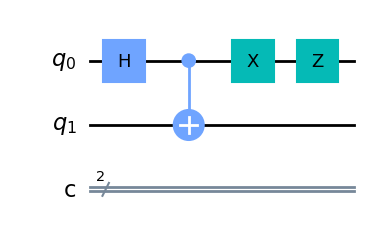

In [3]:
alice_bob_qubits = QuantumCircuit(2, 2)

alice_bob_qubits.h(0)
alice_bob_qubits.cx(0, 1)
alice_bob_qubits.x(0)
alice_bob_qubits.z(0)

alice_bob_qubits.draw()

#### **Step #2: Alice randomly chooses 1 of 3 circuits to apply to each of her qubits.**

The E91 protocol introduces a slightly different set of options for Alice. They all follow the same format: Rotate around the Z axis by some amount and apply an H gate.  

In this step, we will define the three circuits and choose one at random as follows:

1. Define the 0 Rotation and H Gate Option.
2. Define the $\frac{\pi}{4}$ (45°) Rotation and H Gate Option.
3. Define the $\frac{\pi}{2}$ (90°) Rotation and H Gate Option.
4. Alice chooses at random.

<br>

**NOTE**: There is nothing special about these exact three choices from a quantum mechanical standpoint. But, they are the choices originally proposed by Ekert as the rotation gates are relatively simple to understand when looked at on a Bloch sphere. At the end of the day, if they were good enough for him then they're good enough for us!

##### **1. Define the 0 Rotation and H Gate Option.**

**Run the code below to create this circuit with 1 qubit and 1 classical bit for Alice's measurement.**

In [4]:
alice_option_1 = QuantumCircuit(1, 1)

alice_option_1.h(0)

alice_option_1.measure(0, 0)

##### **2. Define the $\frac{\pi}{4}$ (45°) Rotation and H Gate Option.**

In [5]:
alice_option_2 = QuantumCircuit(1, 1)

alice_option_2.rz(math.pi/4, 0)

alice_option_2.h(0)

alice_option_2.measure(0, 0)

##### **3. Define the $\frac{\pi}{2}$ (90°) Rotation and H Gate Option.**

In [6]:
alice_option_3 = QuantumCircuit(1, 1)

alice_option_3.rz(math.pi/2, 0)

alice_option_3.h(0)

alice_option_3.measure(0, 0)

##### **4. Alice chooses at random.**

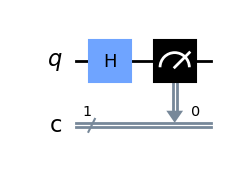

In [7]:
alice_options = [alice_option_1, alice_option_2, alice_option_3]
alice_choice = random.randint(0, 2)

alice_circuit = alice_options[alice_choice]
alice_circuit.draw()

#### **Step 3: Alice measures her qubits.**

Lastly, Alice must use her randomly chosen circuit to measure her half of the Bell pair.


**Run the code below to perform this step.**

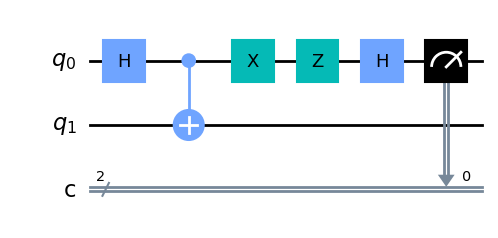

In [8]:
alice_bob_qubits = alice_bob_qubits.compose(alice_circuit, qubits = 0, clbits = 0)

alice_bob_qubits.draw()

---

<center>

### **End of Phase 1**

</center>

---

---
### **Part 1.2:  Phase 2 - Makes Choices and Measures**


In this section, we will implement the next 2 steps of the protocol:

> **Step 4**: Bob randomly chooses 1 or 3 circuits to apply to each of his qubits.
>
> **Step 5**: Bob measures his qubits.

#### **Step #4: Bob randomly chooses 1 or 3 circuits to apply to each of his qubits.**

In this step, Bob chooses from his own set of circuits. Although they are of the same general form as Alice's (Z rotation and then H gate), they are different. As such, perform this step as follows:

1. Define the $\frac{\pi}{4}$ (45°) Rotation and H Gate Option.
2. Define the $\frac{\pi}{2}$ (90°) Rotation and H Gate Option.
3. Define the $\frac{3\pi}{4}$ (135°) Rotation and H Gate Option.
4. Bob chooses at random.

##### **1. Define the $\frac{\pi}{4}$ (45°) Rotation and H Gate Option.**

In [9]:
bob_option_1 = QuantumCircuit(1, 1)

bob_option_1.rz(math.pi/4, 0)
bob_option_1.h(0)

bob_option_1.measure(0, 0)

##### **2. Define the $\frac{\pi}{2}$ (90°) Rotation and H Gate Option.**

In [10]:
bob_option_2 = QuantumCircuit(1, 1)

bob_option_2.rz(math.pi/2, 0)
bob_option_2.h(0)

bob_option_2.measure(0, 0)

##### **3. Define the $\frac{3\pi}{4}$ (135°) Rotation and H Gate Option.**

In [11]:
bob_option_3 = QuantumCircuit(1, 1)

bob_option_3.rz(3 * (math.pi/4), 0)
bob_option_3.h(0)

bob_option_3.measure(0, 0)

##### **4. Bob chooses at random.**

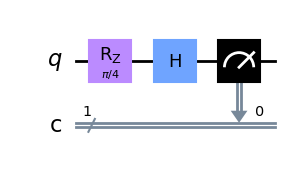

In [12]:
bob_options = [bob_option_1,bob_option_2, bob_option_3]
bob_choice = random.randint(0, 2)

bob_circuit = bob_options[bob_choice]
bob_circuit.draw()

#### **Step 3: Bob measures his qubits.**

Lastly, Bob must use his randomly chosen circuit to measure his half of the Bell pair.


**Run the code below to perform this step.**

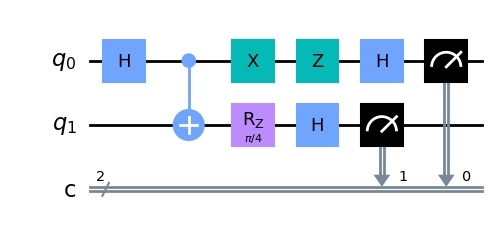

In [13]:
alice_bob_qubits = alice_bob_qubits.compose(bob_circuit, qubits = 1, clbits = 1)

alice_bob_qubits.draw()

#### **Simulate the Measurements Before Moving On.**

##### **Run the code below to simulate Alice's and Bob's measurement results.**

<br>


**Notice**: In the original state that Alice and Bob shared, $|\beta_{11} \rangle = \frac{1}{\sqrt 2}(|01\rangle - |10\rangle)$, their bits always had to be the opposite of each other. Unless they happened to rotate the qubits by the same amount, this is no longer true!

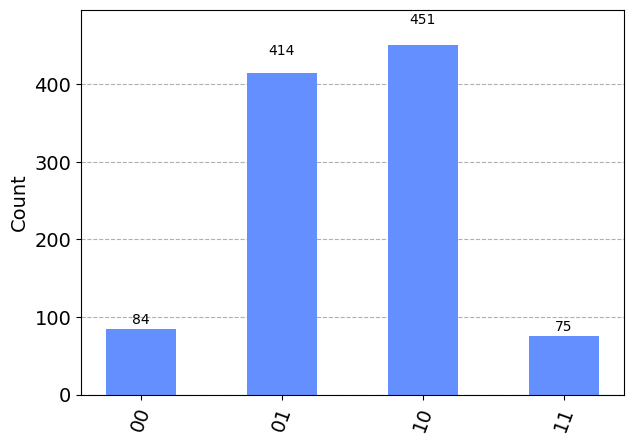

In [14]:
backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1024)


result = job.result()
counts = result.get_counts()

bits = random.choices(list(counts.keys()), weights = counts.values(), k = 1)[0]
alice_bits = bits[0]
bob_bits = bits[1]


plot_histogram(counts)

---

<center>

### **End of Phase 2**

</center>

---

---
### **Part 1.3: Phase 3 - Alice and Bob Compare Choices**


In this section, we will implement the last step of the protocol:

> **Step 6**: Alice and Bob compare choices, sorting into two groups:
1. *Matching choices*: Alice and Bob each create their own key from these.
1. *Mismatching choices*: Alice and Bob tell each other their measurement results and test how entangled they were. If Eve has intercepted, the entanglement between Alice and Bob will be less than expected.

#### **Step 6: Alice and Bob compare choices.**

Very importantly in this step, Alice and Bob are comparing the **circuits themselves**. So "matching choices" consist of:

* Alice's 2nd Option and Bob's 1st Option, both $\frac{\pi}{4}$ rotations.
* Alice's 3rd Option and Bob's 2nd Option, both $\frac{\pi}{2}$ rotations.

<br>


**Run the code below to perform this step.**


<br>

**NOTE**: Since we are only dealing with one qubit and no Eve interceptions, this will not produce particularly interesting results. The main goal here is for you to see how this step works in general so that you can understand it further in the following sections.

In [15]:
alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []


# MATCHING CHOICE
if alice_options[alice_choice] == bob_options[bob_choice]:
  alice_key += [int(alice_bits[0])]
  bob_key += [1 - int(bob_bits[0])]

# MISMATCHING CHOICE
else:
  alice_mismatched_choices += [alice_choice]
  bob_mismatched_choices += [bob_choice]

  alice_mismatched_choice_bits += [alice_bits[0]]
  bob_mismatched_choice_bits += [bob_bits[0]]


entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))

Entanglement of Mismatched Choices: 1.0
Alice's Key: []
Bob's Key: []


**Before continuing**, review your work here and make sure you understand why the following happens:

1. If Alice and Bob make the same choice (apply the same circuit), then they keep the bit for their key.
1. Furthermore, when Alice and Bob keep a bit for their key, Bob flips his measurement result as shown in the code by `1 - int(bob_bits[0])`.
3. Could Alice flip her measurement result instead?

---

<center>

### **End of the Protocol**

</center>

---

## **Part 2: E91 Protocol for Multiple Qubits**
---

In this section, we will apply the components you developed in Part 1 to the full E91 protocol.

### **Exercise #1**

To make building the multiple qubit version of E91 easier, complete the code below with your solutions from above to see the protocol in full for one qubit.

<br>

**NOTE**: This is only including the key pieces that may need to be redefined for each run. For example, we do not need to redefine Alice's and Bob's different circuit options every time, but we do need to randomly pick a new one every time.

In [16]:
#========
# STEP 1
#========
alice_bob_qubits = QuantumCircuit(2, 2)
alice_bob_qubits.h(0)
alice_bob_qubits.cx(0, 1)
alice_bob_qubits.x(0)
alice_bob_qubits.z(0)

alice_bob_qubits.draw()


#========
# STEP 2
#========
alice_option_1 = QuantumCircuit(1, 1)

alice_option_1.h(0)

alice_option_1.measure(0, 0)

alice_option_2 = QuantumCircuit(1, 1)

alice_option_2.rz(math.pi/4, 0)

alice_option_2.h(0)

alice_option_2.measure(0, 0)

alice_option_3 = QuantumCircuit(1, 1)

alice_option_3.rz(math.pi/2, 0)

alice_option_3.h(0)

alice_option_3.measure(0, 0)

alice_options = [alice_option_1, alice_option_2, alice_option_3]

alice_choice = random.randint(0, 2)
alice_circuit = alice_options[alice_choice]
alice_circuit.draw()

#========
# STEP 3
#========
alice_bob_qubits = alice_bob_qubits.compose(alice_circuit, qubits = 0, clbits = 0)


#========
# STEP 4
#========
bob_option_1 = QuantumCircuit(1, 1)

bob_option_1.rz(math.pi/4, 0)
bob_option_1.h(0)

bob_option_1.measure(0, 0)

bob_option_2 = QuantumCircuit(1, 1)

bob_option_2.rz(math.pi/2, 0)
bob_option_2.h(0)

bob_option_2.measure(0, 0)

bob_option_3 = QuantumCircuit(1, 1)

bob_option_3.rz(3 * (math.pi/4), 0)
bob_option_3.h(0)

bob_option_3.measure(0, 0)
bob_options = [bob_option_1,bob_option_2, bob_option_3]
bob_choice = random.randint(0, 2)
bob_circuit = bob_options[bob_choice]
bob_circuit.draw()


#========
# STEP 5
#========
alice_bob_qubits = alice_bob_qubits.compose(bob_circuit, qubits = 1, clbits = 1)


#======================
# SIMULATE THE CIRCUIT
#======================
backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1024)
result = job.result()
counts = result.get_counts()

bits = random.choices(list(counts.keys()), weights = counts.values(), k = 1)[0]
alice_bits = bits[0]
bob_bits = bits[1]
plot_histogram(counts)


#========
# STEP 6
#========
alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []


# MATCHING CHOICE
if alice_options[alice_choice] == bob_options[bob_choice]:
  alice_key += [int(alice_bits[0])]
  bob_key += [1 - int(bob_bits[0])]

# MISMATCHING CHOICE
else:
  alice_mismatched_choices += [alice_choice]
  bob_mismatched_choices += [bob_choice]

  alice_mismatched_choice_bits += [alice_bits[0]]
  bob_mismatched_choice_bits += [bob_bits[0]]


entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))

Entanglement of Mismatched Choices: -1.0
Alice's Key: []
Bob's Key: []


### **Exercise #2**

Modify each step to work for $n$ qubits instead of just $1$.

**Run the code below to define $n$ for this exercise.**

In [11]:
n = 100

#### **Step 1: Alice and Bob share a Bell pair.**

Now, they must share $n$ Bell pairs. Complete the code below to create $n$ circuits that each start by creating the $|\beta_{11}\rangle$ state.

In [12]:
alice_bob_qubits = []

for i in range(n):
  alice_bob_qubits += [QuantumCircuit(2, 2)]
  alice_bob_qubits[i].h(0)
  alice_bob_qubits[i].cx(0, 1)
  alice_bob_qubits[i].x(0)
  alice_bob_qubits[i].z(0)

#### **Step 2: Alice randomly chooses 1 of 3 circuits to apply to each of her qubits.**

In [13]:
alice_choices = []
alice_circuits = []

for i in range(n):
    choice = random.randint(0, 2)
    alice_choices += [random.randint(0, 2)]
    
    alice_option_1 = QuantumCircuit(1, 1)
    alice_option_1.h(0)
    alice_option_1.measure(0, 0)
    
    alice_option_2 = QuantumCircuit(1, 1)
    alice_option_2.rz(math.pi/4, 0)
    alice_option_2.h(0)
    alice_option_2.measure(0, 0)
    
    alice_option_3 = QuantumCircuit(1, 1)
    alice_option_3.rz(math.pi/2, 0)
    alice_option_3.h(0)
    alice_option_3.measure(0, 0)

    alice_options = [alice_option_1, alice_option_2, alice_option_3]
    alice_circuits += [alice_options[choice]]

#### **Step 3: Alice measures her qubits.**

In [14]:
for i in range(n):
  alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuits[i], qubits=0, clbits=0)

#### **Step 4: Bob randomly chooses 1 of 3 circuits to apply to each of his qubits.**

In [15]:
bob_choices = []
bob_circuits = []


for i in range(n):
    choice = random.randint(0, 2)
    bob_choices += [choice]
    
    bob_option_1 = QuantumCircuit(1, 1)
    bob_option_1.rz(math.pi/4, 0)
    bob_option_1.h(0)
    bob_option_1.measure(0, 0)
    
    bob_option_2 = QuantumCircuit(1, 1)
    bob_option_2.rz(math.pi/2, 0)
    bob_option_2.h(0)
    bob_option_2.measure(0, 0)

    bob_option_3 = QuantumCircuit(1, 1)
    bob_option_3.rz(3 * (math.pi/4), 0)
    bob_option_3.h(0)
    bob_option_3.measure(0, 0)
    
    bob_options = [bob_option_1,bob_option_2, bob_option_3]
    bob_circuits += [bob_options[choice]]


#### **Step 5: Bob measures his qubits.**

In [16]:
# COMPLETE THIS CODE
for i in range(n):
  alice_bob_qubits[i] = alice_bob_qubits[i].compose(bob_circuits[i], qubits=1, clbits=1)

#### **Simulate the Circuit**

In [23]:
backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

alice_bits = []
bob_bits = []
for i in range(n):
  bits = list(counts[i].keys())[0]
  alice_bits += [bits[0]]
  bob_bits += [bits[1]]

#### **Step 6: Alice and Bob compare choices.**

In [20]:
alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []

for i in range(n):

  # MATCHING CHOICE
  if alice_options[alice_choices[i]] == bob_options[bob_choices[i]]:
    alice_key += [int(alice_bits[i])]
    bob_key += [1 - int(bob_bits[i])]

  # MISMATCHING CHOICE
  else:
    alice_mismatched_choices += [alice_choices[i]]
    bob_mismatched_choices += [bob_choices[i]]
    
    alice_mismatched_choice_bits += [alice_bits[i]]
    bob_mismatched_choice_bits +=  [bob_bits[i]]


entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))
print("Key Length: " + str(len(bob_key)))
print("Number of Disagreeing Key Bits: " + str(sum([alice_key[i] != bob_key[i] for i in range(len(alice_key))])))

Entanglement of Mismatched Choices: -0.7238095238095239
Alice's Key: [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0]
Bob's Key: [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
Key Length: 22
Number of Disagreeing Key Bits: 8


### **Exercise #3**

Similar to Exercise #1, put all the code for the $n$ qubit E91 protocol into one cell below.

In [24]:
#========
# STEP 1
#========
n = 100

alice_bob_qubits = []

for i in range(n):
  alice_bob_qubits += [QuantumCircuit(2, 2)]

  alice_bob_qubits[i].h(0)
  alice_bob_qubits[i].cx(0, 1)
  alice_bob_qubits[i].x(0)
  alice_bob_qubits[i].z(0)

#========
# STEP 2
#========
alice_choices = []
alice_circuits = []

for i in range(n):
    choice = random.randint(0, 2)
    alice_choices += [random.randint(0, 2)]
    
    alice_option_1 = QuantumCircuit(1, 1)
    alice_option_1.h(0)
    alice_option_1.measure(0, 0)
    
    alice_option_2 = QuantumCircuit(1, 1)
    alice_option_2.rz(math.pi/4, 0)
    alice_option_2.h(0)
    alice_option_2.measure(0, 0)
    
    alice_option_3 = QuantumCircuit(1, 1)
    alice_option_3.rz(math.pi/2, 0)
    alice_option_3.h(0)
    alice_option_3.measure(0, 0)

    alice_options = [alice_option_1, alice_option_2, alice_option_3]
    alice_circuits += [alice_options[choice]]


#========
# STEP 3
#========

for i in range(n):
  alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuits[i], qubits=0, clbits=0)


#========
# STEP 4
#========

bob_choices = []
bob_circuits = []


for i in range(n):
    choice = random.randint(0, 2)
    bob_choices += [choice]
    
    bob_option_1 = QuantumCircuit(1, 1)
    bob_option_1.rz(math.pi/4, 0)
    bob_option_1.h(0)
    bob_option_1.measure(0, 0)
    
    bob_option_2 = QuantumCircuit(1, 1)
    bob_option_2.rz(math.pi/2, 0)
    bob_option_2.h(0)
    bob_option_2.measure(0, 0)

    bob_option_3 = QuantumCircuit(1, 1)
    bob_option_3.rz(3 * (math.pi/4), 0)
    bob_option_3.h(0)
    bob_option_3.measure(0, 0)
    
    bob_options = [bob_option_1,bob_option_2, bob_option_3]
    bob_circuits += [bob_options[choice]]



#========
# STEP 5
#========

# COMPLETE THIS CODE
for i in range(n):
  alice_bob_qubits[i] = alice_bob_qubits[i].compose(bob_circuits[i], qubits=1, clbits=1)

#======================
# SIMULATE THE CIRCUIT
#======================

backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

alice_bits = []
bob_bits = []
for i in range(n):
  bits = list(counts[i].keys())[0]
  alice_bits += [bits[0]]
  bob_bits += [bits[1]]

#========
# STEP 6
#========

alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []

for i in range(n):

  # MATCHING CHOICE
  if alice_options[alice_choices[i]] == bob_options[bob_choices[i]]:
    alice_key += [int(alice_bits[i])]
    bob_key += [1 - int(bob_bits[i])]

  # MISMATCHING CHOICE
  else:
    alice_mismatched_choices += [alice_choices[i]]
    bob_mismatched_choices += [bob_choices[i]]
    
    alice_mismatched_choice_bits += [alice_bits[i]]
    bob_mismatched_choice_bits +=  [bob_bits[i]]


entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))
print("Key Length: " + str(len(bob_key)))
print("Number of Disagreeing Key Bits: " + str(sum([alice_key[i] != bob_key[i] for i in range(len(alice_key))])))


Entanglement of Mismatched Choices: -1.558645276292335
Alice's Key: [0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1]
Bob's Key: [0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Key Length: 18
Number of Disagreeing Key Bits: 3


### **Questions**

You have now implemented the full $n$ qubit E91 protocol without any interception. Before moving on, make sure you understand the answers to the following questions:

1. The average key length is $\frac{2}{9}n$. Why? **Hint**: Consider what needs to happen for bits to be included in the key and how many ways this can happen.

1. The amount of entanglement being reported says how Alice's and Bob's measurements are related. The more often their measurements agree (00 or 11), the more positive the entanglement gets. The more often their measurements disagree (01 or 10), the more negative the entanglement gets. What results are you tending to see above and why do they make sense?

<br>

**NOTE**: The theoretical amount of entanglement for *many* qubits is $-2\sqrt 2 \approx -2.8$, but it is unlikely that you would get exactly this amount.

## **Part 3: Eve Intercepts!**
---

Lastly, you will add Eve's interception to the protocol. In BB84, Eve could intercept when Alice sent qubits to Bob. However, In E91 Alice and Bob never send each other any qubits! So, instead Eve:
1. Sneaks into the lab after Alice and Bob shared their Bell states and go out for lunch. She measures the qubits before Alice and Bob leave.

1. She then prepares new qubits in the states she measured ($|01\rangle$ or $|10\rangle$ each).

1. Later on, she listens in when Alice and Bob compare their choices and keeps only the bits corresponding to the times when Alice and Bob's choices matched.


As we will see, Alice and Bob are not being reckless by leaving their qubits behind in the lab because Alice and Bob can always detect when Eve has intercepted.

### **Exercise #1**

Eve intercepts right after Step #1 by sneaking into the lab after Alice and Bob shared their Bell states and go out for lunch. She measures the qubits before Alice and Bob leave.


**Complete the code below to perform this step.**

In [25]:
#========
# STEP 1
#========
n = 100
alice_bob_qubits = []

for i in range(n):
  alice_bob_qubits += [QuantumCircuit(2, 2)]

  alice_bob_qubits[i].h(0)
  alice_bob_qubits[i].cx(0, 1)
  alice_bob_qubits[i].x(0)
  alice_bob_qubits[i].z(0)


#================
# EVE INTERCEPTS!
#================
for i in range(n):
  alice_bob_qubits[i].measure([0, 1], [0, 1])

backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

### **Exercise #2**

Eve then prepares new qubits in the states she measured ($|01\rangle$ or $|10\rangle$ each).


**Complete the code below to perform this step.**

In [26]:
eve_alice_bits = []
eve_bob_bits = []

for i in range(n):
  # Looks at measurement results
  bits = list(counts[i].keys())[0]
  eve_alice_bits += [bits[0]]
  eve_bob_bits += [bits[1]]

  # Prepares new qubits for Alice and Bob
  alice_bob_qubits[i] = QuantumCircuit(2, 2)
  
  # Makes sure they are in the same state she measured
  if eve_alice_bits[i] == 1: alice_bob_qubits[i].x(0)
  if eve_bob_bits[i] == 1: alice_bob_qubits[i].x(1)


### **Exercise #3**

Then Alice and Bob leave with their qubits and no idea that Eve intercepted. So, they carry out Steps #2 - 5 and perform the measurements.


**Copy the relevant code from Part 2 into the cell below.**

In [27]:
#========
# STEP 2
#========
alice_choices = []
alice_circuits = []

for i in range(n):
    choice = random.randint(0, 2)
    alice_choices += [random.randint(0, 2)]
    
    alice_option_1 = QuantumCircuit(1, 1)
    alice_option_1.h(0)
    alice_option_1.measure(0, 0)
    
    alice_option_2 = QuantumCircuit(1, 1)
    alice_option_2.rz(math.pi/4, 0)
    alice_option_2.h(0)
    alice_option_2.measure(0, 0)
    
    alice_option_3 = QuantumCircuit(1, 1)
    alice_option_3.rz(math.pi/2, 0)
    alice_option_3.h(0)
    alice_option_3.measure(0, 0)

    alice_options = [alice_option_1, alice_option_2, alice_option_3]
    alice_circuits += [alice_options[choice]]


#========
# STEP 3
#========

for i in range(n):
  alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuits[i], qubits=0, clbits=0)


#========
# STEP 4
#========

bob_choices = []
bob_circuits = []


for i in range(n):
    choice = random.randint(0, 2)
    bob_choices += [choice]
    
    bob_option_1 = QuantumCircuit(1, 1)
    bob_option_1.rz(math.pi/4, 0)
    bob_option_1.h(0)
    bob_option_1.measure(0, 0)
    
    bob_option_2 = QuantumCircuit(1, 1)
    bob_option_2.rz(math.pi/2, 0)
    bob_option_2.h(0)
    bob_option_2.measure(0, 0)

    bob_option_3 = QuantumCircuit(1, 1)
    bob_option_3.rz(3 * (math.pi/4), 0)
    bob_option_3.h(0)
    bob_option_3.measure(0, 0)
    
    bob_options = [bob_option_1,bob_option_2, bob_option_3]
    bob_circuits += [bob_options[choice]]



#========
# STEP 5
#========

# COMPLETE THIS CODE
for i in range(n):
  alice_bob_qubits[i] = alice_bob_qubits[i].compose(bob_circuits[i], qubits=1, clbits=1)

#======================
# SIMULATE THE CIRCUIT
#======================

backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

alice_bits = []
bob_bits = []
for i in range(n):
  bits = list(counts[i].keys())[0]
  alice_bits += [bits[0]]
  bob_bits += [bits[1]]


#======================
# SIMULATE THE CIRCUIT
#======================

backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

alice_bits = []
bob_bits = []
for i in range(n):
  bits = list(counts[i].keys())[0]
  alice_bits += [bits[0]]
  bob_bits += [bits[1]]


### **Exercise #4**

Now, Eve listens in when Alice and Bob compare their choices and keeps only the bits corresponding to the times when Alice and Bob's choices matched.


**Copy and modify your Step #6 code from Part 2 in the cell below.**

In [29]:
#========
# STEP 6
#========
alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []

eve_key = []

for i in range(n):

  # MATCHING CHOICE
  if alice_choices[i] == bob_choices[i]:
    
    # Alice and Bob share their choice, but Eve has eavesdropped on the communication
    if alice_options[alice_choices[i]] != bob_options[bob_choices[i]]:
      alice_mismatched_choices += [alice_choices[i]]
      bob_mismatched_choices += [bob_choices[i]]
      alice_mismatched_choice_bits += [int(alice_bits[i])]
      bob_mismatched_choice_bits +=  [int(bob_bits[i])]
      eve_key += [int(alice_bits[i])]  # Eve knows this bit
      
    # All three parties have the same choice
    else:
      alice_key += [int(alice_bits[i])]
      bob_key += [1 - int(bob_bits[i])]
  
  # MISMATCHING CHOICE
  else:
    alice_mismatched_choices += [alice_choices[i]]
    bob_mismatched_choices += [bob_choices[i]]
    
    alice_mismatched_choice_bits += [int(alice_bits[i])]
    bob_mismatched_choice_bits +=  [int(bob_bits[i])]



entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))
print("Eve's Key: " + str(eve_key))
print("Key Length: " + str(len(bob_key)))
print("Number of Disagreeing Key Bits between Alice and Bob: " + str(sum([alice_key[i] != bob_key[i] for i in range(len(alice_key))])))
print("Number of Disagreeing Key Bits between Alice and Eve: " + str(sum([alice_key[i] != eve_key[i] for i in range(len(alice_key))])))
print("Number of Disagreeing Key Bits between Bob and Eve: " + str(sum([bob_key[i] != eve_key[i] for i in range(len(alice_key))])))

Entanglement of Mismatched Choices: 0.38730158730158726
Alice's Key: []
Bob's Key: []
Eve's Key: [0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Key Length: 0
Number of Disagreeing Key Bits between Alice and Bob: 0
Number of Disagreeing Key Bits between Alice and Eve: 0
Number of Disagreeing Key Bits between Bob and Eve: 0


### **Exercise #5**

Now, put all your code into one cell below so that you can easily run this protocol many times.

In [33]:
#========
# STEP 1
#========
n = 100
alice_bob_qubits = []

for i in range(n):
  alice_bob_qubits += [QuantumCircuit(2, 2)]

  alice_bob_qubits[i].h(0)
  alice_bob_qubits[i].cx(0, 1)
  alice_bob_qubits[i].x(0)
  alice_bob_qubits[i].z(0)


#================
# EVE INTERCEPTS!
#================
for i in range(n):
  alice_bob_qubits[i].measure([0, 1], [0, 1])

backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

eve_alice_bits = []
eve_bob_bits = []

for i in range(n):
  # Looks at measurement results
  bits = list(counts[i].keys())[0]
  eve_alice_bits += [bits[0]]
  eve_bob_bits += [bits[1]]

  # Prepares new qubits for Alice and Bob
  alice_bob_qubits[i] = QuantumCircuit(2, 2)
  
  # Makes sure they are in the same state she measured
  if eve_alice_bits[i] == 1: alice_bob_qubits[i].x(0)
  if eve_bob_bits[i] == 1: alice_bob_qubits[i].x(1)


#========
# STEP 2
#========
alice_choices = []
alice_circuits = []

for i in range(n):
    choice = random.randint(0, 2)
    alice_choices += [random.randint(0, 2)]
    
    alice_option_1 = QuantumCircuit(1, 1)
    alice_option_1.h(0)
    alice_option_1.measure(0, 0)
    
    alice_option_2 = QuantumCircuit(1, 1)
    alice_option_2.rz(math.pi/4, 0)
    alice_option_2.h(0)
    alice_option_2.measure(0, 0)
    
    alice_option_3 = QuantumCircuit(1, 1)
    alice_option_3.rz(math.pi/2, 0)
    alice_option_3.h(0)
    alice_option_3.measure(0, 0)

    alice_options = [alice_option_1, alice_option_2, alice_option_3]
    alice_circuits += [alice_options[choice]]


#========
# STEP 3
#========

for i in range(n):
  alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuits[i], qubits=0, clbits=0)


#========
# STEP 4
#========

bob_choices = []
bob_circuits = []


for i in range(n):
    choice = random.randint(0, 2)
    bob_choices += [choice]
    
    bob_option_1 = QuantumCircuit(1, 1)
    bob_option_1.rz(math.pi/4, 0)
    bob_option_1.h(0)
    bob_option_1.measure(0, 0)
    
    bob_option_2 = QuantumCircuit(1, 1)
    bob_option_2.rz(math.pi/2, 0)
    bob_option_2.h(0)
    bob_option_2.measure(0, 0)

    bob_option_3 = QuantumCircuit(1, 1)
    bob_option_3.rz(3 * (math.pi/4), 0)
    bob_option_3.h(0)
    bob_option_3.measure(0, 0)
    
    bob_options = [bob_option_1,bob_option_2, bob_option_3]
    bob_circuits += [bob_options[choice]]



#========
# STEP 5
#========

# COMPLETE THIS CODE
for i in range(n):
  alice_bob_qubits[i] = alice_bob_qubits[i].compose(bob_circuits[i], qubits=1, clbits=1)

#======================
# SIMULATE THE CIRCUIT
#======================

backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

alice_bits = []
bob_bits = []
for i in range(n):
  bits = list(counts[i].keys())[0]
  alice_bits += [bits[0]]
  bob_bits += [bits[1]]


#======================
# SIMULATE THE CIRCUIT
#======================

backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

alice_bits = []
bob_bits = []
for i in range(n):
  bits = list(counts[i].keys())[0]
  alice_bits += [bits[0]]
  bob_bits += [bits[1]]


#========
# STEP 6
#========
alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []

eve_key = []

for i in range(n):

  # MATCHING CHOICE
  if alice_choices[i] == bob_choices[i]:
    
    # Alice and Bob share their choice, but Eve has eavesdropped on the communication
    if alice_options[alice_choices[i]] != bob_options[bob_choices[i]]:
      alice_mismatched_choices += [alice_choices[i]]
      bob_mismatched_choices += [bob_choices[i]]
      alice_mismatched_choice_bits += [int(alice_bits[i])]
      bob_mismatched_choice_bits +=  [int(bob_bits[i])]
      eve_key += [int(alice_bits[i])]  # Eve knows this bit
      
    # All three parties have the same choice
    else:
      alice_key += [int(alice_bits[i])]
      bob_key += [1 - int(bob_bits[i])]
  
  # MISMATCHING CHOICE
  else:
    alice_mismatched_choices += [alice_choices[i]]
    bob_mismatched_choices += [bob_choices[i]]
    
    alice_mismatched_choice_bits += [int(alice_bits[i])]
    bob_mismatched_choice_bits +=  [int(bob_bits[i])]



entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))
print("Eve's Key: " + str(eve_key))
print("Key Length: " + str(len(bob_key)))
print("Number of Disagreeing Key Bits between Alice and Bob: " + str(sum([alice_key[i] != bob_key[i] for i in range(len(alice_key))])))
print("Number of Disagreeing Key Bits between Alice and Eve: " + str(sum([alice_key[i] != eve_key[i] for i in range(len(alice_key))])))
print("Number of Disagreeing Key Bits between Bob and Eve: " + str(sum([bob_key[i] != eve_key[i] for i in range(len(alice_key))])))

Entanglement of Mismatched Choices: 0.5764705882352941
Alice's Key: []
Bob's Key: []
Eve's Key: [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]
Key Length: 0
Number of Disagreeing Key Bits between Alice and Bob: 0
Number of Disagreeing Key Bits between Alice and Eve: 0
Number of Disagreeing Key Bits between Bob and Eve: 0


## **Wrapping Up**

*Congratulations!* You have implemented the E91 protocol in qiskit -- something quantum networks will likely be relying on for security quite soon. To wrap up, please make sure to write a summary of the concepts covered here, including answers to the following questions:

1. How does Eve's interception change the amount of entanglement Alice and Bob share? Why?

1. Imagine that Eve attempts to go unnoticed by preparing Alice and Bob's qubits back into the $|\beta_{11}\rangle$ state instead of whatever her measurement results were. Answer these two questions based on this scenario:
  * Would this accomplish Eve's goal of going unnoticed? **Hint**: Think about how the entanglement would or would not change in this case. Consider writing code to test this.
  * Why does this still keep Eve from learning Alice's and Bob's key?

1. In BB84, Alice decides the key at the very beginning and tries communicating it to Bob securely. That is not the case in E91. *When* in the protocol is the key officially created? **Hint**: It's before Alice and Bob actually create their keys.

# Summary 

In this project, we explored the BB84 quantum key distribution protocol, which allows two parties, Alice and Bob, to share a secret key securely. We went through the steps of the protocol, including the preparation of qubits, the transmission of qubits over a noisy channel, the measurement of qubits, and the comparison of measurement results to establish the secret key. We also examined the role of an eavesdropper, Eve, in the protocol and how they can potentially disrupt the security of the key exchange.

# Answers to the above questions

## Question 1 : How does Eve's interception change the amount of entanglement Alice and Bob share? Why?

Eve's interception changes the amount of entanglement Alice and Bob share by reducing it. Entanglement is a key feature of the BB84 protocol that enables Alice and Bob to establish a secret key. By measuring and potentially manipulating the qubits that Alice sends to Bob, Eve disrupts the entanglement, reducing the probability that Alice and Bob will have matching measurement results, and therefore reducing the amount of entanglement they share.
## Question 2 : Imagine that Eve attempts to go unnoticed by preparing Alice and Bob's qubits back into the |𝛽11⟩ state instead of whatever her measurement results were. Answer these two questions based on this scenario:

### Would this accomplish Eve's goal of going unnoticed? Hint: Think about how the entanglement would or would not change in this case. Consider writing code to test this.

No, this would not accomplish Eve's goal of going unnoticed. If Eve prepares Alice and Bob's qubits back into the |𝛽11⟩ state instead of whatever their measurement results were, she would still have disrupted the entanglement between the qubits. When Alice and Bob measure their qubits, they would not have matching results, and this would be apparent to them. Therefore, Eve's tampering would not go unnoticed.

### Why does this still keep Eve from learning Alice's and Bob's key?
This still keeps Eve from learning Alice's and Bob's key because the BB84 protocol relies on the principles of quantum mechanics to ensure the security of the key exchange. By preparing the qubits back into the |𝛽11⟩ state, Eve would not gain any information about the key because the qubits are in a superposition of states until they are measured. Therefore, even if Eve knows the initial state of the qubits, they still cannot obtain the key without measuring the qubits, which would be detected by Alice and Bob.

## Question 3 : In BB84, Alice decides the key at the very beginning and tries communicating it to Bob securely. That is not the case in E91. When in the protocol is the key officially created? Hint: It's before Alice and Bob actually create their keys.

In E91, the key is officially created when the qubits are measured by Alice and Bob. During this phase, Alice and Bob compare a subset of their measurement results to detect any potential eavesdropping by Eve. If they detect any discrepancies, they abort the protocol. If not, they use the remaining measurement results to create their keys, using classical post-processing techniques to correct any errors that may have occurred during transmission. Therefore, the key is created after the transmission of qubits and the measurement of qubits.


# End of Lab

---

© 2023 The Coding School, All rights reserved